In [1]:
import numpy as np
from functools import partial
import ipywidgets as widgets
from IPython.display import display

In [2]:
#pydrake imports
from pydrake.all import RationalForwardKinematics
from pydrake.geometry.optimization import IrisOptions, HPolyhedron, Hyperellipsoid
from pydrake.solvers import MosekSolver, CommonSolverOption, SolverOptions
from pydrake.all import PiecewisePolynomial, InverseKinematics, Sphere, Rgba, RigidTransform, RotationMatrix, IrisInConfigurationSpace
import time
import pydrake
from pydrake.all import (SceneGraphCollisionChecker, 
                         StartMeshcat, 
                         RobotDiagramBuilder,
                         ProcessModelDirectives,
                         LoadModelDirectives,
                         MeshcatVisualizer)
from pydrake.all import GeometrySet, CollisionFilterDeclaration
from scipy.special import comb
import matplotlib.pyplot as plt


In [3]:
# meshcat = StartMeshcat()

In [4]:
from pydrake.all import Role, MeshcatVisualizerParams
def plant_builder(usemeshcat = False):
    if usemeshcat:
        meshcat = StartMeshcat()
    builder = RobotDiagramBuilder()
    plant = builder.plant()
    scene_graph = builder.scene_graph()
    parser = builder.parser()
    #parser.package_map().Add("cvisirisexamples", missing directory)
    if usemeshcat:
        meshcat_params = MeshcatVisualizerParams()
#         meshcat_params.role = Role.kProximity
        visualizer = MeshcatVisualizer.AddToBuilder(builder.builder(), scene_graph, meshcat,meshcat_params)
    directives_file = "7_dof_directives_newshelf.yaml"#FindResourceOrThrow() 
    directives = LoadModelDirectives(directives_file)
    models = ProcessModelDirectives(directives, plant, parser)
    
#     collision_filter_manager = scene_graph.collision_filter_manager()
#     inspector = scene_graph.model_inspector()
#     schunk_body = plant.GetBodyByName("body")
#     iiwa_link_7 = plant.GetBodyByName("iiwa_link_7")
#     iiwa_link_6 = plant.GetBodyByName("iiwa_link_6")
#     iiwa_links = [plant.GetBodyByName(f"iiwa_link_{i}") for i in range(8)]
#     bodies = []
#     for b in iiwa_links+[schunk_body]:#[schunk_body, iiwa_link_7, iiwa_link_6]:
#         bodies += plant.GetCollisionGeometriesForBody(b)
#     geom_set = GeometrySet(bodies)
#     decl = CollisionFilterDeclaration().ExcludeWithin(geom_set)
#     collision_filter_manager.Apply(decl)

#     shelves = [plant.GetBodyByName(f"shelf{i}",
#                                   plant.GetModelInstanceByName(f"shelves{i}")) for i in range(1,3)]
#     bodies = []
#     for b in iiwa_links[:5]+shelves:
#         bodies += plant.GetCollisionGeometriesForBody(b)
#     geom_set = GeometrySet(bodies)
#     decl = CollisionFilterDeclaration().ExcludeWithin(geom_set)
#     collision_filter_manager.Apply(decl)
    
    plant.Finalize()
    diagram = builder.Build()
    diagram_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(diagram_context)
    diagram.ForcedPublish(diagram_context)
    return plant, scene_graph, diagram, diagram_context, plant_context, meshcat if usemeshcat else None

plant, scene_graph, diagram, diagram_context, plant_context, meshcat = plant_builder(usemeshcat=True)

scene_graph_context = scene_graph.GetMyMutableContextFromRoot(
    diagram_context)
import pydrake.multibody.rational as rational_forward_kinematics
from pydrake.all import RationalForwardKinematics
Ratfk = RationalForwardKinematics(plant)

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [5]:
# def compute_max_psd_size(plane_order, plant_deg, path_deg, num_objects = 100):
#     poly_to_prove_pos_degree = plane_order + plant_deg * path_deg
#     d = np.floor(poly_to_prove_pos_degree/2)
#     max_psd_size = comb(d+2,2)
# #     num_psd_needed = 8 * 2 * num_objects # everything is a box
#     return max_psd_size

# # plane_orders = np.arange(1, 11)
# plane_order = 5
# plant_degs = np.arange(2, 21)
# path_degs = np.arange(1,4)
# scaling_per_plant_deg = []
# for plant_deg in plant_degs:
#     ret = []
#     for path_deg in path_degs:
#         ret.append(compute_max_psd_size(plane_order, plant_deg, path_deg))
#     scaling_per_plant_deg.append(np.array(ret))
#     plt.plot(
#         path_degs, scaling_per_plant_deg[-1], marker = "o", label=f"plant_degree = {plant_deg}"
#     )
# plt.xlabel("path degree")
# plt.ylabel("maximum size of PSD matrix")
# plt.legend()
    
# from pydrake.all import MathematicalProgram
# prog = MathematicalProgram()
# Qs = []
# for i in range(8):
#     poly_to_prove_pos_degree = plane_order + plant_degs[-1] * path_degs[-1]
#     d = np.floor(poly_to_prove_pos_degree/2)
#     Qs.append(
#         prog.NewSymmetricContinuousVariables(int(d),"Q"))
#     prog.AddPositiveSemidefiniteConstraint(Qs[0])
              
       
    
        


In [ ]:
from pydrake.geometry.optimization_dev import CspaceFreePath
q_star = np.zeros(plant.num_positions())
plane_order = 6
max_degree = 3
t0 = time.time()
cspace_free_path = CspaceFreePath(
    plant,
    scene_graph,
    q_star,
    maximum_path_degree=max_degree,
    plane_order=plane_order,
)
t1 = time.time()
print(f"Time to build collision checker {t1-t0}")

In [25]:
# for plane_geom in cspace_free_path.plane_geometries_on_path():
#     max_deg = 0
#     for c in plane_geom.positive_side_conditions + plane_geom.negative_side_conditions:
#         max_deg = max(max_deg, c.get_p().TotalDegree())
#     print(max_deg)
#     print()
# print(f"Expected max = {2*np.ceil(plant.num_positions()/2)+plane_order}")

8

8

8

8

8

8

8

8

8

8

8

8

8

8

8

8

8

8

8

8

8

8

10

10

10

10

10

10

10

10

10

10

10

10

10

10

10

10

10

10

10

10

10

10

12

12

12

12

12

12

12

12

12

12

12

12

12

12

12

12

12

12

12

12

12

12

12

12

12

12

14

14

14

14

14

14

14

14

14

14

14

14

14

14

14

14

14

14

14

14

14

14

14

14

14

14

Expected max = 14.0


62248.0


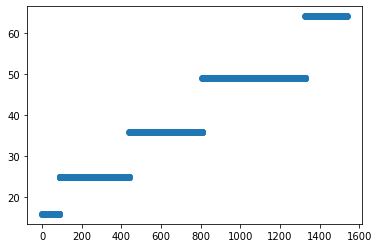

In [27]:
# total_size_psd = 0
# psd_sizes = []
# for plane_geom in cspace_free_path.plane_geometries_on_path():
#     for c in plane_geom.positive_side_conditions + plane_geom.negative_side_conditions:
#         size = comb(c.get_lambda().TotalDegree()/2+2, 2) + comb(c.get_nu().TotalDegree()/2+2, 2)
#         total_size_psd += size
#         psd_sizes.append(size)
# print(total_size_psd)
# psd_sizes.sort()
# plt.scatter(np.arange(len(psd_sizes)), np.array(psd_sizes))

In [42]:
# total_num_psd = 0
# for plane_geom in cspace_free_path.plane_geometries_on_path():
#     for c in plane_geom.positive_side_conditions + plane_geom.negative_side_conditions:
#         expected_psd_size = comb(c.get_lambda().TotalDegree()/2+2, 2) + comb(c.get_nu().TotalDegree()/2+2, 2)
#         expected_plane_vars =  (plane_order+1)*4
#         if expected_psd_size + expected_plane_vars != c.get_psatz_variables_and_psd_constraints().num_vars():
#             print(c.get_poly())
# #         print(c.get_lambda().indeterminates())
#         print()
# #         print(c.get_psatz_variables_and_psd_constraints())
#     break
#     print()

(-1 + 0.10387400000000001 * plane_var2 + 0.103937 * plane_var5 + plane_var11 + 0.207874 * (s_0(mu_3)_coeff * plane_var2) - 0.20774800000000002 * (s_0(mu_3)_coeff * plane_var5) - 0.10387400000000001 * (pow(s_0(mu_3)_coeff, 2) * plane_var2) - 0.103937 * (pow(s_0(mu_3)_coeff, 2) * plane_var5) + (pow(s_0(mu_3)_coeff, 2) * plane_var11) - pow(s_0(mu_3)_coeff, 2))*1 + (0.10387400000000001 * plane_var1 + 0.103937 * plane_var4 + plane_var10 - 2 * (s_0(mu_2)_coeff * s_0(mu_3)_coeff) - 0.20774800000000002 * (s_0(mu_2)_coeff * s_0(mu_3)_coeff * plane_var2) - 0.207874 * (s_0(mu_2)_coeff * s_0(mu_3)_coeff * plane_var5) + 2 * (s_0(mu_2)_coeff * s_0(mu_3)_coeff * plane_var11) + 0.207874 * (s_0(mu_2)_coeff * plane_var2) - 0.20774800000000002 * (s_0(mu_2)_coeff * plane_var5) + 0.207874 * (s_0(mu_3)_coeff * plane_var1) - 0.20774800000000002 * (s_0(mu_3)_coeff * plane_var4) - 0.10387400000000001 * (pow(s_0(mu_3)_coeff, 2) * plane_var1) - 0.103937 * (pow(s_0(mu_3)_coeff, 2) * plane_var4) + (pow(s_0(mu_3)_c

In [14]:
sliders = []
for i in range(plant.num_positions()):
    q_low = plant.GetPositionLowerLimits()[i]
    q_high = plant.GetPositionUpperLimits()[i]
    sliders.append(widgets.FloatSlider(min=q_low, max=q_high, value=0, description=f"q{i}"))

q = np.zeros(plant.num_positions())
ik = InverseKinematics(plant, plant_context)
collision_constraint = ik.AddMinimumDistanceConstraint(0.001, 0.001)
def eval_cons(q, c, tol):
    return 1-1*float(c.evaluator().CheckSatisfied(q, tol))
diagram_col_context = diagram.CreateDefaultContext()
plant_col_context = diagram.GetMutableSubsystemContext(plant, diagram_col_context)
scene_graph_col_context = diagram.GetMutableSubsystemContext(
        scene_graph, diagram_col_context
    )
query_port = scene_graph.get_query_output_port()


def check_collision_q_by_query(q):
#     if np.all(q >= plant.GetPositionLowerLimits()) and np.all(
#         q <= plant.GetPositionUpperLimits()
#     ):
#         plant.SetPositions(plant_context, q)
#         query_object = query_port.Eval(scene_graph_context)
# #         if query_object.HasCollisions():
# #         print(query_object.ComputePointPairPenetration())
#         return 1 if query_object.HasCollisions() else 0
#     else:
#         print("exiting position limits")
#         print(np.logical_and(q >= plant.GetPositionLowerLimits(), 
#         q <= plant.GetPositionUpperLimits()))
#         print(plant.GetPositionLowerLimits())
#         print(q)

#         print(plant.GetPositionUpperLimits())
#         print()
#         return 1
    plant.SetPositions(plant_context, q)
    query_object = query_port.Eval(scene_graph_context)
#         if query_object.HasCollisions():
#         print(query_object.ComputePointPairPenetration())
    return 1 if query_object.HasCollisions() else 0
    

def check_collision_s_by_query(s):
    s = np.array(s)
    q = Ratfk.ComputeQValue(s, q_star)
    return check_collision_q_by_query(q)


    
col_func_handle = check_collision_q_by_query#partial(eval_cons, c=collision_constraint, tol=0.01)
# col_func_handle = partial(eval_cons, c=collision_constraint, tol=0.01)

col_shunk_col =  Rgba(0.8, 0.0, 0, 0.5)    
col_shunk_free =  Rgba(0.0, 0.8, 0.5, 0.5)   

def handle_slider_change(change, idx):
    q[idx] = change['new']
    showres(q)

def showres_s(s_vis):
    showres(Ratfk.ComputeQValue(s_vis, np.zeros(7)))

def showres(qvis):
    plant.SetPositions(plant_context, qvis)
    col = col_func_handle(qvis)
    shunk = plant.get_body(pydrake.multibody.tree.BodyIndex(9))
    tf_tot = shunk.EvalPoseInWorld(plant_context)
    tf = tf_tot.translation()
    
   # tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
    #tf = tf_tot.translation() - tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
    if col:
        meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_col)
    else:
        meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_free)
    meshcat.SetTransform(f"/drake/visualizer/shunk",
                                   RigidTransform(RotationMatrix(),
                                                  tf))
    
    diagram.ForcedPublish(diagram_context)

scaler = 1 #np.array([0.8, 1., 0.8, 1, 0.8, 1, 0.8]) #do you even geometry bro?
q_min = np.array(q_low)*scaler
q_max = np.array(q_high)*scaler
q_diff = q_max-q_min

# def sample_cfree_QPoint(MAXIT=1000):
# 	it = 0
# 	while it<MAXIT:
# 		rand = np.random.rand(5)
# 		q_s = q_min + rand*q_diff
# 		col = False
# 		for _ in range(10):
# 			r  = 0.05*(np.random.rand(5)-0.5)
# 			col |= (col_func_handle(q_s+r) > 0)
# 		if not col:
# 			return q_s #Ratfk.ComputeQValue(q_s, q_star)
# 		it+=1
# 	raise ValueError("no col free point found")

idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

display(sliders[0])
for slider in sliders:
    display(slider)

FloatSlider(value=0.0, description='q0', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='q0', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='q1', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='q2', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='q3', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='q4', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='q5', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='q6', max=3.05433, min=-3.05433)

In [15]:
waypoints =  np.array([[-2.06706, -0.3944 ,  1.43294,  0.9056 ,  0.53294, -0.8944 ,
        0.74567],
[-2.26706, -0.3944 ,  1.43294,  0.9056 ,  0.73294, -0.9944 ,
        1.04567],
[-2.96706, -0.344 ,  2.83294,  0.9056 ,  0.73294, -0.9944 ,
        1.04567],
[-1.06706,  0.1056 ,  2.43294,  0.9056 ,  0.73294,  0.2056 ,
        1.04567],
[-1.06706,  0.1056 ,  2.43294,  1.1056 ,  1.73294,  0.2056 ,
        0.0567],
[-1.56706,  0.1056 ,  2.43294,  1.2056 ,  1.73294,  0.8056 ,
       -0.25433]])

waypoints_col = waypoints.copy()

# waypoints_col[1,:]=np.array([-2.36706, -0.3344 ,  1.43294,  0.8956 ,  0.73294, -0.9944 ,
#         1.04567])
waypoints_col[1,:]=np.array([-2.22706, -0.3944 ,  1.43294,  0.9056 ,  0.73294, -0.9944 ,
        1.04567])
#np.array([-2.0706, -0.3244 ,  1.43294,  0.8756 ,  0.73294, -0.9944 ,
#      1.04567])
from scipy.interpolate import CubicSpline

t = np.linspace(0, 1, waypoints.shape[0])
coord_splines = [CubicSpline(t,waypoints[:,i]) for i in range(7)]
t_refined = np.linspace(0,1,30)
waypoints_q_refined = [[c(t) for c in coord_splines]for t in t_refined] 

t = np.linspace(0, 1, waypoints_col.shape[0])
coord_splines = [CubicSpline(t,waypoints_col[:,i]) for i in range(7)]
t_refined = np.linspace(0,1,30)
waypoints_q_col_refined = [[c(t) for c in coord_splines]for t in t_refined] 

waypoints_s = np.array([Ratfk.ComputeSValue(w, np.zeros(7)) for w in waypoints_q_refined])
t = np.linspace(0, 1, waypoints_s.shape[0])
coord_splines_s = [CubicSpline(t,waypoints_s[:,i]) for i in range(7)]
t_refined = np.linspace(0,1,200)
waypoints_s_refined = np.array([[c(t) for c in coord_splines_s]for t in t_refined] )

waypoints_s_col = np.array([Ratfk.ComputeSValue(w, np.zeros(7)) for w in waypoints_q_col_refined])
t = np.linspace(0, 1, waypoints_s_col.shape[0])
coord_splines_s_col = [CubicSpline(t,waypoints_s_col[:,i]) for i in range(7)]
t_refined = np.linspace(0,1,200)
waypoints_s_col_refined = np.array([[c(t) for c in coord_splines_s_col]for t in t_refined] )

#waypoints_q_backtransf = np.array([Ratfk.ComputeQValue(w, np.zeros(7)) for w in waypoints_s_refined])



In [16]:
# showres(waypoints_col[1,:])

In [17]:
# for w in waypoints_s_col_refined:
#     showres_s(w)
# #     break
#     time.sleep(0.05)

In [18]:
def plot_endeff_traj_s(dense,name = '', color = (1,0,0,1)):
    plot_endeff_traj(np.array([Ratfk.ComputeQValue(w,np.zeros(7)) for w in dense]), name, color)

def plot_endeff_traj(dense_waypoints, name = '', color= (1,0,0,1)):
    color = Rgba(color[0], color[1], color[2], color[3])
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        plant.SetPositions(plant_context, qa)
        tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(9)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.13

        meshcat.SetObject(f"/iris/points/traj/{name}/{i+start_idx}",
                               Sphere(0.01),
                               color)

        meshcat.SetTransform(f"/iris/points/traj/{name}/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))

In [19]:
# plot_endeff_traj_s(waypoints_s_refined, 'free',(0,1,0,1))
# plot_endeff_traj_s(waypoints_s_col_refined, 'col',(1,0,0,1))
# #plot_endeff_traj(waypoints_q_backtransf, 'qb',(1,0.5,1,1))

In [22]:
# for sa in waypoints_s_refined:
#     #qa = #Ratfk.ComputeQValue(ta, np.zeros(3))
#     showres_s(sa)
#     if col_func_handle(Ratfk.ComputeQValue(sa, np.zeros(7))):
#         print(col_func_handle(Ratfk.ComputeQValue(sa, np.zeros(7))))
#         query_object = query_port.Eval(scene_graph_context)
#         print(query_object.HasCollisions())
#         break
        
#     time.sleep(0.01)

In [23]:
# for sa in waypoints_s_col_refined:
#     #qa = #Ratfk.ComputeQValue(ta, np.zeros(3))
#     showres_s(sa)
#     if col_func_handle(Ratfk.ComputeQValue(sa, np.zeros(7))):
#         print('col')
# #         break
#     time.sleep(0.01)

In [24]:
#this is how you get the breakpoints and coefficients of the collision free spline

print(f"breakpoints: {coord_splines_s[0].x.shape}")

print(f"coefficients: {coord_splines_s[0].c.shape}")

breakpoints: (30,)
coefficients: (4, 29)


In [25]:
#this is how you get the breakpoints and coefficients of the spline with collision

print(f"breakpoints: {coord_splines_s_col[0].x.shape}")

print(f"coefficients: {coord_splines_s_col[0].c.shape}")

breakpoints: (30,)
coefficients: (4, 29)


In [26]:
import time
from pydrake.geometry.optimization_dev import CspaceFreePath


In [27]:
from pydrake.all import PiecewisePolynomial
from pydrake.polynomial import Polynomial as CommonPolynomial
import logging
drake_logger = logging.getLogger("drake")
drake_logger.setLevel(logging.DEBUG)

breaks = np.arange(0, waypoints_s.shape[0])
samples = waypoints_s
derivs = np.zeros_like(waypoints_s)
traj = PiecewisePolynomial.CubicHermite(breaks,samples.T, derivs.T)
polys =np.array([traj.getPolynomialMatrix(i) for i in breaks[:-1]]).squeeze().T


In [28]:
polys[0,0].GetDegree()

3

In [29]:
q_star = np.zeros(plant.num_positions())
plane_order = 2
max_degree = 3
t0 = time.time()
cspace_free_path = CspaceFreePath(
    plant,
    scene_graph,
    q_star,
    maximum_path_degree=max_degree,
    plane_order=plane_order,
)
t1 = time.time()
print(f"Time to build collision checker {t1-t0}")

Time to build collision checker 395.07769680023193


In [30]:
len(cspace_free_path.separating_planes())

96

In [31]:
# for plane in cspace_free_path.separating_planes():
#     pos_body_idx = plane.positive_side_geometry.body_index()
#     neg_body_idx = plane.negative_side_geometry.body_index()
#     pos_body_name = plant.get_body(pos_body_idx).name()
#     neg_body_name = plant.get_body(neg_body_idx).name()
#     print(pos_body_name, neg_body_name)
print(len(cspace_free_path.separating_planes()))

96


In [32]:
cert_options = CspaceFreePath.FindSeparationCertificateGivenPathOptions()
cert_options.terminate_segment_certification_at_failure = False
cert_options.num_threads = -1
cert_options.verbose = False
cert_options.solver_id = MosekSolver.id()
cert_options.solver_options = SolverOptions()
cert_options.terminate_path_certification_at_failure = False

In [ ]:
t0 = time.time()
stats, res = cspace_free_path.FindSeparationCertificateGivenPath(polys,
                                                                 set(),
                                                                 cert_options)
t1 = time.time()
print(f"Time to certify path {t1-t0}")

In [25]:
res

[{(<GeometryId value=51>, <GeometryId value=95>): None,
  (<GeometryId value=51>, <GeometryId value=107>): None,
  (<GeometryId value=39>, <GeometryId value=89>): None,
  (<GeometryId value=51>, <GeometryId value=131>): None,
  (<GeometryId value=51>, <GeometryId value=101>): None,
  (<GeometryId value=51>, <GeometryId value=157>): None,
  (<GeometryId value=63>, <GeometryId value=101>): None,
  (<GeometryId value=45>, <GeometryId value=157>): None,
  (<GeometryId value=45>, <GeometryId value=143>): None,
  (<GeometryId value=51>, <GeometryId value=119>): None,
  (<GeometryId value=63>, <GeometryId value=119>): None,
  (<GeometryId value=39>, <GeometryId value=137>): None,
  (<GeometryId value=45>, <GeometryId value=89>): None,
  (<GeometryId value=39>, <GeometryId value=143>): None,
  (<GeometryId value=45>, <GeometryId value=125>): None,
  (<GeometryId value=57>, <GeometryId value=143>): None,
  (<GeometryId value=27>,
   <GeometryId value=137>): <pydrake.geometry.optimization_dev.Cs

In [24]:
for r in res:
    for k, v in r.items():
        if v is not None:
            v

SyntaxError: invalid syntax (3034944604.py, line 4)

In [ ]:
ur = UrDiagram(num_ur = 1, weld_wrist = True, add_shelf = True,
                 add_gripper = True, use_meshcat=True)
diagram_context = ur.diagram.CreateDefaultContext()
diagram = ur.diagram.ForcedPublish(diagram_context)

plant_context = ur.plant.GetMyMutableContextFromRoot(
        diagram_context)
scene_graph_context = ur.scene_graph.GetMyMutableContextFromRoot(
    diagram_context)
inspector = ur.scene_graph.model_inspector()        
        
# # construct the RationalForwardKinematics of this plant. This object handles the
# # computations for the forward kinematics in the tangent-configuration space
# Ratfk = RationalForwardKinematics(ur.plant)

# # the point about which we will take the stereographic projections
# q_star = np.zeros(ur.plant.num_positions())

# # The object we will use to perform our certification.
# cspace_free_polytope = CspaceFreePolytope(ur.plant, ur.scene_graph,
#                                           SeparatingPlaneOrder.kAffine, q_star)

#from pydrake.all import Box, GetVertices
query = ur.scene_graph.get_query_output_port().Eval(ur.scene_graph.GetMyContextFromRoot(diagram_context))
inspector = query.inspector()
a = inspector.GetCollisionCandidates()
geomids= []
for b, c in a:
    geomids.append(b)
    geomids.append(c)
ids = list(set(inspector.GetAllGeometryIds()))
frame_id_dict = {}
for idx in range(len(ids)):
    #print(idx, plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])))
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='body':
        frame_id_dict['body'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='left_finger':
        frame_id_dict['left_finger'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='right_finger':
        frame_id_dict['right_finger'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='ur_wrist_3_link':
        frame_id_dict['ur_wrist_3_link'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='ur_wrist_2_link':
        frame_id_dict['ur_wrist_2_link'] = ids[idx]

print(frame_id_dict)
geom_ids = [inspector.GetGeometries(inspector.GetFrameId(frame_id_dict[k]))[0] for k in ['ur_wrist_2_link','ur_wrist_3_link','body', 'left_finger', 'right_finger']]

sh_frames = [6,7, 11,12,13]
sh_geom = [inspector.GetShape(id) for id in geom_ids] 
sh_names = ['ur_wrist_2_link','ur_wrist_3_link', 'box', 'l','r']

def plot_endeff_pose(q2, name = '', color = Rgba(1,1,0.1,0.8)):
    ur.plant.SetPositions(plant_context, q2)
    tfs = [ur.plant.EvalBodyPoseInWorld(plant_context, ur.plant.get_body(pydrake.multibody.tree.BodyIndex(fr))) for fr in sh_frames]
    for n, f, geom in zip(sh_names[2:], tfs[2:], sh_geom[2:]):
        #print(n,f,geom)
        ur.meshcat.SetObject("/iris/shunk/"+name+"/"+n,
                                geom,
                                color)
        ur.meshcat.SetTransform("/iris/shunk/"+name+"/"+n, f)
# for i,p in enumerate(poi):
#     plot_endeff_pose(p, str(i))
def densify_waypoints(waypoints_q):
    densify = 200
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints_q[:-1])):
        a = waypoints_q[idx]
        b = waypoints_q[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        dists_endeff = []
        for tval in t:
            a = a*tval + b*(1-tval)
            qa = a#Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            ur.plant.SetPositions(plant_context, qa)
            tf_tot= ur.plant.EvalBodyPoseInWorld(plant_context, ur.plant.get_body(pydrake.multibody.tree.BodyIndex(11)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
            locs_endeff.append(tf)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints_q[idx]*tval + waypoints_q[idx+1]*(1-tval))
    return dense_waypoints

def plot_endeff_traj(dense_waypoints):
    color = Rgba(1,0,0,1.0)
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        ur.plant.SetPositions(plant_context, qa)
        tf_tot= ur.plant.EvalBodyPoseInWorld(plant_context, ur.plant.get_body(pydrake.multibody.tree.BodyIndex(11)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15

        ur.meshcat.SetObject(f"/iris/points/traj/{i+start_idx}",
                               Sphere(0.005),
                               color)

        ur.meshcat.SetTransform(f"/iris/points/traj/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))



In [ ]:
import pickle
import os

exp_name = "5DOf_ur_20230703210916_16_1000_0.050_0.140"#"5DOf_ur_20230703162006_12_1000_0.050_0.140"
poly_names = os.listdir("logs/"+exp_name+"/regions")
data_chkpts = os.listdir("logs/"+exp_name+"/data")
poly_names.sort()
data_chkpts.sort()
regions = []
for p in poly_names:
    with open("logs/"+exp_name+"/regions/"+p, 'rb') as f:
        d = pickle.load(f)
    regions.append(HPolyhedron(d['ra'], d['rb']))

with open("logs/"+exp_name+"/data/"+data_chkpts[-1], 'rb') as f:
    d2 = pickle.load(f)

seed_points = d2['sp'][-1]

In [ ]:
showres(seed_points[0, :])

In [ ]:
def conversion_dummy(q):
    return q
import dijkstraspp
dspp = dijkstraspp.DijkstraSPPsolver(regions, conversion_dummy)

In [ ]:
sliders = []
for i in range(ur.plant.num_positions()):
    q_low = ur.plant.GetPositionLowerLimits()[i]
    q_high = ur.plant.GetPositionUpperLimits()[i]
    sliders.append(widgets.FloatSlider(min=q_low, max=q_high, value=0, description=f"q{i}"))

q = np.zeros(ur.plant.num_positions())
ik = InverseKinematics(ur.plant, plant_context)
collision_constraint = ik.AddMinimumDistanceConstraint(0.001, 0.001)
def eval_cons(q, c, tol):
    return 1-1*float(c.evaluator().CheckSatisfied(q, tol))
    
col_func_handle = partial(eval_cons, c=collision_constraint, tol=0.01)
col_shunk_col =  Rgba(0.8, 0.0, 0, 0.5)    
col_shunk_free =  Rgba(0.0, 0.8, 0.5, 0.5)   

def handle_slider_change(change, idx):
    q[idx] = change['new']
    showres_regions(q)

def showres(qvis):
    ur.plant.SetPositions(plant_context, qvis)
    col = col_func_handle(qvis)
    shunk = ur.plant.get_body(pydrake.multibody.tree.BodyIndex(11))
    tf_tot = shunk.EvalPoseInWorld(plant_context)
    tf = tf_tot.translation()
    
   # tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
    #tf = tf_tot.translation() - tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
    if col:
        ur.meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_col)
    else:
        ur.meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_free)
    ur.meshcat.SetTransform(f"/drake/visualizer/shunk",
                                   RigidTransform(RotationMatrix(),
                                                  tf))
    
    ur.diagram.ForcedPublish(diagram_context)

from visibility_utils import point_in_regions

def showres_regions(qvis):
    ur.plant.SetPositions(plant_context, qvis)
    is_in_regions = False #point_in_regions(qvis, regions)
    col = col_func_handle(qvis)
    shunk = ur.plant.get_body(pydrake.multibody.tree.BodyIndex(11))
    tf_tot = shunk.EvalPoseInWorld(plant_context)
    tf = tf_tot.translation()
    
   # tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
    #tf = tf_tot.translation() - tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
    if col:
        ur.meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_col)
    else:
        ur.meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_free)
    
    ur.meshcat.SetTransform(f"/drake/visualizer/shunk",
                                   RigidTransform(RotationMatrix(),
                                                 tf))
    
        
    if is_in_regions:
        ur.meshcat.SetObject(f"/drake/visualizer/inreg",
                                   Sphere(0.2),
                                   col_shunk_free)
    else:
        ur.meshcat.SetObject(f"/drake/visualizer/inreg",
                                   Sphere(0.2),
                                   col_shunk_col)
    ur.meshcat.SetTransform(f"/drake/visualizer/inreg",
                                   RigidTransform(RotationMatrix(),
                                                  np.array([0.5,0,0.5])))
    
    ur.diagram.ForcedPublish(diagram_context)

scaler = 1 #np.array([0.8, 1., 0.8, 1, 0.8, 1, 0.8]) #do you even geometry bro?
q_min = np.array(q_low)*scaler
q_max = np.array(q_high)*scaler
q_diff = q_max-q_min

def sample_cfree_QPoint(MAXIT=1000):
	it = 0
	while it<MAXIT:
		rand = np.random.rand(5)
		q_s = q_min + rand*q_diff
		col = False
		for _ in range(10):
			r  = 0.05*(np.random.rand(5)-0.5)
			col |= (col_func_handle(q_s+r) > 0)
		if not col:
			return q_s #Ratfk.ComputeQValue(q_s, q_star)
		it+=1
	raise ValueError("no col free point found")

idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

display(sliders[0])
for slider in sliders:
    display(slider)

In [ ]:
ur.plant

In [ ]:
points = np.array([sample_cfree_QPoint() for i in range(50)])

In [ ]:
from pydrake.all import VisibilityGraph
from pydrake.all import SceneGraphCollisionChecker, CollisionCheckerParams


In [ ]:
ccp = CollisionCheckerParams()

In [ ]:
ccp.

In [ ]:
VisibilityGraph()

In [ ]:
SceneGraphCollisionChecker(ur.scene_graph, ur.diagram)

In [ ]:
ur.diagram

In [ ]:
q = seed_points[0, :].copy()
print(q)

In [ ]:
import time
centers = [r.ChebyshevCenter() for r in regions]
start = centers[0]
for _ in range(50):
    #nxt = vs.sample_in_regions() #
    while True:
        nxt = sample_cfree_QPoint()#centers[np.random.choice(len(centers))]
        plot_endeff_pose(nxt, str(0))
        if nxt[0] != start[0]:
            break
    wp, dist = dspp.solve(start, nxt, refine_path=True)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion, optimize= True)
    print(dist)
    if dist >0:
        dense_waypoints = densify_waypoints(wp)
        plot_endeff_traj(dense_waypoints)
        for qa in dense_waypoints:
            #qa = #Ratfk.ComputeQValue(ta, np.zeros(3))
            showres(qa)
            if col_func_handle(qa):
                print('col')
                break
            time.sleep(0.002)
        start = nxt
        time.sleep(0.01)
        ur.meshcat.Delete("/iris/points/traj/")
        
    else:
        nxt = centers[np.random.choice(len(centers))]

In [ ]:
plot_endeff_pose(centers[25],'0')
plot_endeff_pose(centers[1],'1')




In [ ]:
showres(centers[25])

In [ ]:
# poi = []
# poi.append(np.array([-0.32743, -0.92743,  0.47257,  0.07257, -0.02743]))
# poi.append(np.array([-1.62743, -1.32743,  2.57257, -1.22743, -0.02743]))
# poi.append(np.array([-1.62743, -2.02743,  1.67257,  0.37257, -0.02743]))
# poi.append(np.array([-1.72743, -1.82743, -2.02743,  0.67257, -0.02743]))
# poi.append(np.array([-1.72743, -1.92743,  1.07257, -2.32743, -0.02743]))
# poi.append(np.array([-1.72743, -1.32743, -0.92743, -1.02743, -0.02743]))
# poi.append(np.array([-1.52743, -2.42743,  0.87257, -1.62743, -0.02743]))
# poi.append(np.array([-2.12743, -0.52743, -1.92743,  2.47257, -1.02743]))

In [ ]:
dspp.solve(centers[25], centers[24], refine_path=True)

In [ ]:
snopt_iris_options = IrisOptions()
snopt_iris_options.require_sample_point_is_contained = True
snopt_iris_options.iteration_limit = 8
snopt_iris_options.configuration_space_margin = 1.5e-3
#snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = -1
#snopt_iris_options.q_star = np.zeros(3)
snopt_iris_options.num_collision_infeasible_samples = 15
snopt_iris_options.relative_termination_threshold = 0.02

def SNOPT_IRIS(q_seeds,  region_obstacles, logger, plant, context, snoptiris_options):
	regions = []
	for reg_indx, q_seed in enumerate(q_seeds):
		#q_seed = Ratforwardkin.ComputeQValue(s_seed.reshape(-1,1), np.zeros((7,1)))
		#print('snopt iris call')
		snoptiris_options.configuration_obstacles = []
		if len(region_obstacles):
			snoptiris_options.configuration_obstacles = region_obstacles
		plant.SetPositions(plant.GetMyMutableContextFromRoot(context), q_seed.reshape(-1,1))
		try:
			#r = IrisInRationalConfigurationSpace(plant, plant.GetMyContextFromRoot(context), q_star, snoptiris_options)
			r = IrisInConfigurationSpace(plant, plant_context, snoptiris_options)
			r_red = r.ReduceInequalities()
			print(f"[SNOPT IRIS]: Region:{reg_indx} / {len(q_seeds)}")
			#run the certifier
			# cert = cspace_free_polytope.BinarySearch(set(),
			# 								r.A(),
			# 								r.b(), 
			# 								np.array(s_seed),
			# 								binary_search_options)
			if logger is not None: logger.log_region(r_red)
			# r = cert.certified_polytope
			regions.append(r_red)
		except:
			print("error, SNOPT IRIS FAILED")
	return regions

SNOPT_IRIS_Handle = partial(SNOPT_IRIS,
                            plant = ur.plant,
                            context = diagram_context,
                            snoptiris_options = snopt_iris_options,
			    			#binary_search_options = binary_search_options,
                            #Ratforwardkin = Ratfk,
                            )

In [ ]:
#setup visibility seeding helpers
from visibility_utils import point_in_regions
from tqdm import tqdm
from scipy.sparse import lil_matrix

scaler = 1 #np.array([0.8, 1., 0.8, 1, 0.8, 1, 0.8]) #do you even geometry bro?
q_min = np.array(q_low)*scaler
q_max = np.array(q_high)*scaler
q_diff = q_max-q_min

alpha = 0.05
eps = 0.25
N = 1000
seed = 1
np.random.seed(seed)

def estimate_coverage(regions, pts = 3000):
	pts_ = [sample_cfree_QPoint() for _ in range(pts)]
	inreg = 0
	for pt in pts_:
		if point_in_regions(pt, regions): inreg+=1
	return inreg/pts

def sample_cfree_QPoint(MAXIT=1000):
	it = 0
	while it<MAXIT:
		rand = np.random.rand(5)
		q_s = q_min + rand*q_diff
		col = False
		for _ in range(10):
			r  = 0.05*(np.random.rand(5)-0.5)
			col |= (col_func_handle(q_s+r) > 0)
		if not col:
			return q_s #Ratfk.ComputeQValue(q_s, q_star)
		it+=1
	raise ValueError("no col free point found")

def sample_cfree_QPoint_in_regions(regions):
	for _ in range(1000):
		pt = sample_cfree_QPoint()
		if point_in_regions(pt, regions): return pt
	return None

def sample_cfree_handle(n, m, regions=None):
		points = np.zeros((n,5))
		if regions is None: regions = []		
		for i in range(n):
			bt_tries = 0
			while bt_tries<m:
				point = sample_cfree_QPoint()
				col = False
				for _ in range(10):
					r  = 0.05*(np.random.rand(5)-0.5)
					col |= point_in_regions(point+r, regions)
				if col:
					bt_tries += 1
					if bt_tries == m:
						return points, True 
				else:
					break
			points[i] = point
		return points, False

# def visSSpace(t1, t2, regions, num_checks, visualizer):
# 	t1flat = t1.reshape(-1)
# 	t2flat = t2.reshape(-1)
# 	if np.linalg.norm(t1-t2) < 1e-6:
# 		return (1-col_func_handle(Ratfk.ComputeQValue(t1flat, q_star)))>0
				
# 	tvec = np.linspace(0,1, num_checks)
# 	for t in tvec:
# 		tinterp = t1flat*t + (1-t)*t2flat
# 		if col_func_handle(Ratfk.ComputeQValue(tinterp, q_star)):
# 			return False
# 		elif point_in_regions(tinterp, regions):
# 			return False
# 	else:
# 		return True

def vis(q1, q2, regions, num_checks):
	q1flat = q1.reshape(-1)
	q2flat = q2.reshape(-1)
	if np.linalg.norm(q1-q2) < 1e-6:
		return (1-col_func_handle(q1))>0
				
	tvec = np.linspace(0,1, num_checks)
	for t in tvec:
		qinterp = q1flat*t + (1-t)*q2flat
		if col_func_handle(qinterp):
			return False
		elif point_in_regions(qinterp, regions):
			return False
	else:
		return True
    
visibility_checker = partial(vis, num_checks = 80)

def vgraph_builder(points, regions):
	n = len(points)
	adj_mat = lil_matrix((n,n))
	for i in tqdm(range(n)):
		point = points[i, :]
		for j in range(len(points[:i])):
			other = points[j]
			result = visibility_checker(point, other, regions)
			#print(result)
			if result:
				adj_mat[i,j] = adj_mat[j,i] = 1
	return adj_mat

In [ ]:
from doublegreedyhiddenset import HiddensetDoubleGreedy

dg = HiddensetDoubleGreedy(
    alpha=alpha,
    eps = 0.01,
    max_samples = 100000,
    sample_node_handle=sample_cfree_handle,
    los_handle=visibility_checker,
    verbose=True
)

In [ ]:
dg.construct_independent_set([])


In [ ]:
dg.refine_independent_set_greedy([])

In [ ]:
from visibility_seeding import VisSeeder
from visibility_logging import Logger
import os
LOAD_CHKPT = True

if not LOAD_CHKPT:
    logger = Logger("5DOf_ur", seed, N, alpha, eps, estimate_coverage)
    VS = VisSeeder(N = N,
                alpha = alpha,
                eps = eps,
                max_iterations = 10,
                sample_cfree = sample_cfree_handle,
                build_vgraph = vgraph_builder,
                iris_w_obstacles = SNOPT_IRIS_Handle,
                verbose = True,
                logger = logger
                )
    out = VS.run()
else:
    pass
    #exp_name = "7DOf_shelves_20230617114513_1_1000_0.050_0.200"
    #poly_names = os.listdir("logs/"+exp_name+"/regions")

In [ ]:
# r_poi = SNOPT_IRIS_Handle(poi, [], None)
# import pickle
# with open('r_poi_UR5_19.pkl', 'wb') as f:
#     d = {'ra': [r.A() for r in r_poi], 'rb': [r.b() for r in r_poi]}
#     pickle.dump(d, f)

In [ ]:
for p in poi:
    print(point_in_regions(p, VS.regions))

In [ ]:
# r_poi = SNOPT_IRIS_Handle(poi, [], None) 

In [ ]:
import pickle
with open('r_poi_UR5.pkl', 'wb') as f:
    d = {'ra': [r.A() for r in r_poi], 'rb': [r.b() for r in r_poi]}
    pickle.dump(d, f)

In [ ]:
import pickle
with open('r_poi_UR5.pkl', 'rb') as f:
   data = pickle.load(f)

r_poi = []
for a,b in zip(data['ra'], data['rb']):
   r_poi.append(HPolyhedron(a,b))

In [ ]:
import pickle
import networkx as nx
from visibility_utils import generate_distinct_colors
import matplotlib.pyplot as plt
import os
exp_name = "5DOf_ur_20230628191053_5_1000_0.050_0.250"
poly_names = os.listdir("logs/"+exp_name+"/regions")
data_chkpts = os.listdir("logs/"+exp_name+"/data")
poly_names.sort()
data_chkpts.sort()
regions = []
for p in poly_names:
    with open("logs/"+exp_name+"/regions/"+p, 'rb') as f:
        d = pickle.load(f)
    regions.append(HPolyhedron(d['ra'], d['rb']))

with open("logs/"+exp_name+"/data/"+data_chkpts[-1], 'rb') as f:
    d = pickle.load(f)

r_poi = []
with open("r_poi_UR5_19.pkl", 'rb') as f:
    drpoi = pickle.load(f)
    for A,b in zip(drpoi['ra'], drpoi['rb']):
        r_poi.append(HPolyhedron(A,b))

region_groups_sizes = [len(g) for g in d['rb']]
len_reg = np.sum(region_groups_sizes) 
region_groups_sizes.append(len(regions)-len_reg)
region_groups = []
idx = 0
for s in region_groups_sizes:
    grp = []
    for i in range(s):
        grp.append(regions[i+idx])
    idx+=len(grp)
    region_groups.append(grp)

regions+=r_poi
region_groups.append(r_poi)
connectivity_graph = nx.Graph()
for idx in range(len(regions)):
    connectivity_graph.add_node(idx)
    
for idx1 in range(len(regions)):
    for idx2 in range(idx1 +1, len(regions)):
        r1 = regions[idx1]
        r2 = regions[idx2]
        if r1.IntersectsWith(r2):
            connectivity_graph.add_edge(idx1,idx2)

fig = plt.figure(figsize=(10,10))
hues = generate_distinct_colors(len(region_groups)+1)[1:]
colors = []
for g, h in zip(region_groups, hues):
    colors += [h]*len(g)

nx.draw_spring(connectivity_graph, 
                with_labels = True, 
                node_color = colors)
plt.show()

In [ ]:
for p in poi:
    print(point_in_regions(p, regions))

In [ ]:
#from pydrake.all import Box, GetVertices
query = ur.scene_graph.get_query_output_port().Eval(ur.scene_graph.GetMyContextFromRoot(diagram_context))
inspector = query.inspector()
a = inspector.GetCollisionCandidates()
geomids= []
for b, c in a:
    geomids.append(b)
    geomids.append(c)
ids = list(set(inspector.GetAllGeometryIds()))
frame_id_dict = {}
for idx in range(len(ids)):
    #print(idx, plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])))
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='body':
        frame_id_dict['body'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='left_finger':
        frame_id_dict['left_finger'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='right_finger':
        frame_id_dict['right_finger'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='ur_wrist_3_link':
        frame_id_dict['ur_wrist_3_link'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='ur_wrist_2_link':
        frame_id_dict['ur_wrist_2_link'] = ids[idx]

print(frame_id_dict)
geom_ids = [inspector.GetGeometries(inspector.GetFrameId(frame_id_dict[k]))[0] for k in ['ur_wrist_2_link','ur_wrist_3_link','body', 'left_finger', 'right_finger']]

sh_frames = [6,7, 11,12,13]
sh_geom = [inspector.GetShape(id) for id in geom_ids] 
sh_names = ['ur_wrist_2_link','ur_wrist_3_link', 'box', 'l','r']

def plot_endeff_pose(q2, name = '', color = Rgba(1,1,0.1,0.8)):
    ur.plant.SetPositions(plant_context, q2)
    tfs = [ur.plant.EvalBodyPoseInWorld(plant_context, ur.plant.get_body(pydrake.multibody.tree.BodyIndex(fr))) for fr in sh_frames]
    for n, f, geom in zip(sh_names, tfs, sh_geom):
        #print(n,f,geom)
        ur.meshcat.SetObject("/iris/shunk/"+name+"/"+n,
                                geom,
                                color)
        ur.meshcat.SetTransform("/iris/shunk/"+name+"/"+n, f)
# for i,p in enumerate(poi):
#     plot_endeff_pose(p, str(i))

In [ ]:
for i in ids:
    #print(ur.plant.GetBodyFromFrameId(inspector.GetFrameId(i)).name())
    print(inspector.GetFrameId(i), ur.plant.GetBodyFromFrameId(inspector.GetFrameId(i)).name())

In [ ]:
plot_endeff_pose(centers[0])

In [ ]:
for i in range(15):
    print(ur.plant.get_body(pydrake.multibody.tree.BodyIndex(i)))

In [ ]:
def densify_waypoints(waypoints_q):
    densify = 200
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints_q[:-1])):
        a = waypoints_q[idx]
        b = waypoints_q[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        dists_endeff = []
        for tval in t:
            a = a*tval + b*(1-tval)
            qa = a#Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            ur.plant.SetPositions(plant_context, qa)
            tf_tot= ur.plant.EvalBodyPoseInWorld(plant_context, ur.plant.get_body(pydrake.multibody.tree.BodyIndex(11)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
            locs_endeff.append(tf)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints_q[idx]*tval + waypoints_q[idx+1]*(1-tval))
    return dense_waypoints

def plot_endeff_traj(dense_waypoints):
    color = Rgba(1,0,0,1.0)
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        ur.plant.SetPositions(plant_context, qa)
        tf_tot= ur.plant.EvalBodyPoseInWorld(plant_context, ur.plant.get_body(pydrake.multibody.tree.BodyIndex(11)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15

        ur.meshcat.SetObject(f"/iris/points/traj/{i+start_idx}",
                               Sphere(0.005),
                               color)

        ur.meshcat.SetTransform(f"/iris/points/traj/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))

In [ ]:
def conversion_dummy(q):
    return q
import dijkstraspp
dspp = dijkstraspp.DijkstraSPPsolver(regions, conversion_dummy)

In [ ]:
# import pickle 

# with open('logs/5DOf_ur_20230619092515_1_1000_0.050_0.250/5DOf_ur_20230619092515_1_1000_0.050_0.250dspp.pkl', 'rb') as f:
#     a = pickle.load(f)

# dspp = a['dspp']

In [ ]:
import time

start = poi[np.random.choice(8)]
for _ in range(50):
    #nxt = vs.sample_in_regions() #
    while True:
        nxt = poi[np.random.choice(8)]
        plot_endeff_pose(nxt, str(0))
        if nxt[0] != start[0]:
            break
    wp, dist = dspp.solve(start, nxt, refine_path=True)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion, optimize= True)
    print(dist)
    if dist >0:
        dense_waypoints = densify_waypoints(wp)
        plot_endeff_traj(dense_waypoints)
        for qa in dense_waypoints:
            #qa = #Ratfk.ComputeQValue(ta, np.zeros(3))
            showres(qa)
            #if col_func_handle(qa):
            #print(col)
            #break
            time.sleep(0.01)
        start = nxt
        time.sleep(0.01)
        ur.meshcat.Delete("/iris/points/traj/")
        
    else:
        nxt = poi[np.random.choice(8)]

In [ ]:
### estimate overlapping region volume
coverage = estimate_coverage(regions, pts = 5000)





In [ ]:
def point_in_regions_multi(pt, regions):
    nr_sets =0
    for r in regions:
        if r.PointInSet(pt.reshape(-1,1)):
            nr_sets+=1
    return nr_sets    

npts = 5000
pts_ = [sample_cfree_QPoint() for _ in range(npts)]
inreg = 0
inreg_mult = []
for pt in pts_:
    nr = point_in_regions_multi(pt, regions)
    if nr>0: 
        inreg+=1
        inreg_mult.append(nr)


In [ ]:
print('coverage est ',  inreg/npts)
mult = 0
for i in  inreg_mult:
    if i>1:
        mult+=1
print('multicoverage fraction est ', mult/npts)

In [ ]:
coverage

In [ ]:
connectivity_graph = nx.Graph()
for idx in range(len(regions)):
    connectivity_graph.add_node(idx)
    
for idx1 in range(len(regions)):
    for idx2 in range(idx1 +1, len(regions)):
        r1 = regions[idx1]
        r2 = regions[idx2]
        if r1.IntersectsWith(r2):
            connectivity_graph.add_edge(idx1,idx2)

fig = plt.figure(figsize=(10,10))
hues = generate_distinct_colors(len(region_groups)+1)[1:]
colors = []
for g, h in zip(region_groups, hues):
    colors += [h]*len(g)

nx.draw_spring(connectivity_graph, 
                with_labels = True, 
                node_color = colors)
plt.show()

In [ ]:
len(connectivity_graph.edges)

In [ ]:
coords = [2,3,4]

q_low_vis = (np.array(ur.plant.GetPositionLowerLimits())[coords]).tolist()
q_high_vis = (np.array(ur.plant.GetPositionUpperLimits())[coords]).tolist()
#coordinates of q0 that are not in coords list are the ones we project onto 
q0 = np.array([0.0,-0.2,0,0,0])



In [ ]:
from  pydrake.all import StartMeshcat, DiagramBuilder, AddMultibodyPlantSceneGraph, MeshcatVisualizer

meshcat2 = StartMeshcat()
builder2 = DiagramBuilder()
plant2, scene_graph2 = AddMultibodyPlantSceneGraph(builder2, time_step=0.0)
vis2 = MeshcatVisualizer.AddToBuilder(builder2, scene_graph2, meshcat2)

In [ ]:
import old_vis_utils as viz_utils
import mcubes
from pydrake.all import  StartMeshcat, MeshcatVisualizer, DiagramBuilder, \
    AddMultibodyPlantSceneGraph, TriangleSurfaceMesh, Rgba, SurfaceTriangle, Sphere

def transfrom_regions(regions, q_proj, dof_coords):
    small_regs = []
    for r in regions:
        A_new = r.A()[:,dof_coords]
        c_dofs = []
        for i in range(5):
            if i not in dof_coords:
                c_dofs.append(i)
        A_const = r.A()[:, c_dofs]  
        b_new = r.b() - A_const@q_proj[c_dofs]
        #check if region is empty
        rn = HPolyhedron(A_new, b_new)
        if not rn.IsEmpty():
            small_regs.append(rn)
        else:
            print("projected region is empty")
    return small_regs

def plot_regions(regions, ellipses = None,
                     region_suffix = '', colors = None,
                     wireframe = False,
                     opacity = 0.7,
                     fill = True,
                     line_width = 10,
                     darken_factor = .2,
                     el_opacity = 0.3):
        if colors is None:
            colors = viz_utils.n_colors_random(len(regions), rgbs_ret=True)

        for i, region in enumerate(regions):
            c = Rgba(*[col/255 for col in colors[i]],opacity)
            prefix = f"/iris/regions{region_suffix}/{i}"
            name = prefix + "/hpoly"
            if region.ambient_dimension() == 3:
                plot_hpoly3d(name, region,
                                  c, wireframe = wireframe, resolution = 50)

def get_plot_poly_mesh(region, resolution):

        def inpolycheck(q0, q1, q2, A, b):
            q = np.array([q0, q1, q2])
            res = np.min(1.0 * (A @ q - b <= 0))
            # print(res)
            return res

        aabb_max, aabb_min = viz_utils.get_AABB_limits(region)

        col_hand = partial(inpolycheck, A=region.A(), b=region.b())
        vertices, triangles = mcubes.marching_cubes_func(tuple(aabb_min),
                                                         tuple(aabb_max),
                                                         resolution,
                                                         resolution,
                                                         resolution,
                                                         col_hand,
                                                         0.5)
        tri_drake = [SurfaceTriangle(*t) for t in triangles]
        return vertices, tri_drake

def plot_hpoly3d( name, hpoly, color, wireframe = True, resolution = 30):
        verts, triangles = get_plot_poly_mesh(hpoly,
                                                   resolution=resolution)
        meshcat2.SetObject(name, TriangleSurfaceMesh(triangles, verts),
                                color, wireframe=wireframe)

In [ ]:
def col_func_handle_vis(qv0,qv1,qv2):
    q_eval = q0.copy()
    q_eval[coords] = np.array([qv0,qv1,qv2])
    return col_func_handle(q_eval)

col_shunk_col =  Rgba(0.8, 0.0, 0, 0.5)    
col_shunk_free =  Rgba(0.0, 0.8, 0.5, 0.5)   


def showres_viz(qv):
    #print(q2)
    
    ur.plant.SetPositions(plant_context, qv) #GetJointByName(f"iiwa_joint_{joint_idx}").set_angle(plant_context, q2[joint_idx-1])
    col = col_func_handle(qv)
    color = Rgba(1, 0.72, 0, 1) if col else Rgba(0.24, 1, 0, 1)
    shunk = ur.plant.get_body(pydrake.multibody.tree.BodyIndex(11))
    tf_tot = shunk.EvalPoseInWorld(plant_context)
    tf = tf_tot.translation()
    #diagram.Publish(context)
    #self.visualize_planes(idx_list)
    #don't change this order
    meshcat2.SetObject(f"/s",
                            Sphere(0.05),
                            color)
    meshcat2.SetTransform(f"/s",
                                RigidTransform(RotationMatrix(),
                                                qv[coords]))
    
    if col:
        ur.meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_col)
    else:
        ur.meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_free)
    ur.meshcat.SetTransform(f"/drake/visualizer/shunk",
                                   RigidTransform(RotationMatrix(),
                                                  tf))
    
    ur.diagram.ForcedPublish(diagram_context)

def visualize_collision_constraint(vis2, N = 50, factor = 1, iso_surface = 0.5, wireframe = True):
        """
        :param N: N is density of marchingcubes grid. Runtime scales cubically in N
        :return:
        """

        vertices, triangles = mcubes.marching_cubes_func(tuple(factor*q_low_vis),
                                                         tuple(factor*q_high_vis),
                                                         N, N, N, col_func_handle_vis, iso_surface)
        tri_drake = [SurfaceTriangle(*t) for t in triangles]
        meshcat2.SetObject("/collision_constraint",
                                      TriangleSurfaceMesh(tri_drake, vertices),
                                      Rgba(1, 0, 0, 0.5), wireframe=wireframe)
        return tri_drake, vertices
tri, v = visualize_collision_constraint(vis2, N=40)

In [ ]:
r_s = transfrom_regions(regions, q0, coords)
plot_regions(r_s)

In [ ]:

sliders2 = []
for joint_id in coords:
    print(coords)
    joint_idx = joint_id + 1
    sliders2.append(
        widgets.FloatSlider(
        min= np.array(ur.plant.GetPositionLowerLimits())[joint_id],##plant.GetJointByName(f"iiwa_joint_{joint_idx}").position_lower_limit(), 
        max= np.array(ur.plant.GetPositionUpperLimits())[joint_id],#plant.GetJointByName(f"iiwa_joint_{joint_idx}").position_upper_limit(), 
        value=0, 
        description=f'ur_joint_{joint_idx}'
        )
    )

q2 = 1.0*q0.copy()

def handle_slider_change_viz(change, idx):
    idch = coords[idx]
    q2[idch] = change['new']
    print(q2[coords[idx]])
    showres_viz(q2)
    
idx = 0
for s in sliders2:
    s.observe(partial(handle_slider_change_viz, idx = idx), names='value')
    idx+=1

for s in sliders2:
    display(s)
    #-0.87237632  1.21614163 -1.68963116

In [ ]:
coords

In [ ]:
for i1, p1 in enumerate(poi[1:]):
    for i2, p2 in enumerate(poi[1:]):
        if i1 !=i2:
            dspp.solve(p1, p2, refine_path=True)

In [ ]:
with open(exp_name + 'dspp.pkl', 'wb') as f:
    pickle.dump({'dspp': dspp}, f)

In [ ]:
dspppath = "logs/5DOf_ur_20230619092515_1_1000_0.050_0.250dspp.pkl"

In [ ]:
from gcs.bezier import BezierGCS

In [ ]:
convex_relaxation = True
b_gcs = BezierGCS(regions, order=5, continuity=2)
b_gcs.addTimeCost(1)
b_gcs.addPathLengthCost(1)
b_gcs.setSolver(MosekSolver())

def solve_path(start, end):
    b_gcs.addSourceTarget(start, end)
    bezier_traj = b_gcs.SolvePath(convex_relaxation)[0]

    samples = np.linspace(bezier_traj.start_time(), bezier_traj.end_time(), 200)
    values = np.squeeze([bezier_traj.value(s) for s in samples])
    return values

In [ ]:
import time


start = poi[1+np.random.choice(7)]
for _ in range(50):
    #nxt = vs.sample_in_regions() #
    while True:
        nxt = poi[1+np.random.choice(7)]
        plot_endeff_pose(nxt, str(0))
        if nxt[0] != start[0]:
            break
    #wp, dist = dspp.solve(start, nxt, refine_path=True)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion, optimize= True)
    dense_waypoints = solve_path(start, nxt)
    dist =1
    if dist >0:
        #dense_waypoints = densify_waypoints(wp)
        plot_endeff_traj(dense_waypoints)
        for qa in dense_waypoints:
            #qa = #Ratfk.ComputeQValue(ta, np.zeros(3))
            showres(qa)
            #if col_func_handle(qa):
            #print(col)
            #break
            time.sleep(0.01)
        start = nxt
        time.sleep(0.01)
        ur.meshcat.Delete("/iris/points/traj/")
        
    else:
        nxt = poi[1+np.random.choice(7)]